## IMPORTS and UTILS

In [1]:
print("hi")

import os
import pandas as pd
import subprocess
import re
import numpy as np
import json
import csv

from joblib import Parallel, delayed
from scipy.stats import pearsonr



import matplotlib.pyplot as plt
import seaborn as sns


import os

from scripts import combat_info
from scripts import combat_quick_apply
from scripts import combat_quick_QC
from robust_evaluation_tools.robust_utils import get_site, robust_text, rwp_text, get_camcan_file, get_diseases, get_metrics, add_nb_patients_and_diseased
from robust_evaluation_tools.robust_harmonization import fit, apply, visualize_harmonization, QC, compare_with_compilation, create_presentation, compare_distances, compare_with_compilation_var
from robust_evaluation_tools.synthectic_sites_generations import generate_sites

MAINFOLDER = "RESULTS/MODELS_ANALYSIS"
SYNTHETIC_SITES = f"{MAINFOLDER}/SYNTHETIC_SITES"

ANALYSIS_FOLDER = f"{MAINFOLDER}/ANALYSIS"


hi


In [2]:
def concat_and_save(folder_path, metrics, prefix="train_"):
    dfs = []

    for metric in metrics:
        filename = f"{prefix}{metric}.csv"
        full_path = os.path.join(folder_path, filename)

        if os.path.exists(full_path):
            df = pd.read_csv(full_path)
            dfs.append(df)

    if dfs:
        final_df = pd.concat(dfs, ignore_index=True)
        save_path = os.path.join(folder_path, f"{prefix}all_metrics.csv")
        final_df.to_csv(save_path, index=False)
        print(f"✅ Sauvegardé : {save_path}")


def process_all_sites(base_folder, metrics,diseases, prefix="train_"):
    for disease in diseases:
        disease_path = os.path.join(base_folder, disease)
        if not os.path.isdir(disease_path):
            continue

        for proportion in os.listdir(disease_path):
            proportion_path = os.path.join(disease_path, proportion)
            if not os.path.isdir(proportion_path):
                continue

            for repetition in os.listdir(proportion_path):
                site_path = os.path.join(proportion_path, repetition)
                if not os.path.isdir(site_path):
                    continue

                print(f"📂 Traitement : {site_path}")
                concat_and_save(site_path, metrics, prefix=prefix)

In [3]:
def calculate_z_score(df,  mean_col="mean_no_cov"):
    # 1. Moyenne et std par metric_bundle
    stats = df.groupby("metric_bundle")[mean_col].agg(['mean', 'std']).rename(columns={'mean': 'global_mean', 'std': 'global_std'})
    stats["global_std"] = stats["global_std"].replace(0, 1e-6)  # éviter division par zéro

    # 2. Merge pour chaque ligne
    df = df.merge(stats, on="metric_bundle", how="left")

    # 3. Calcul du z-score ligne par ligne
    df["abs_zscore"] = ((df[mean_col] - df["global_mean"]) / df["global_std"]).abs()

    # 4. Moyenne des z-scores par patient
    result = df.groupby(["sid", "disease"]).agg(mean_abs_zscore=("abs_zscore", "mean")).reset_index()

    return result


In [4]:

# Function to analyze a single (sample_size, disease_ratio) combination
def process_analysis_z_score(disease, sample_size, disease_ratio,harmonization_method, SYNTHETIC_SITES_VERSION, num_tests):
    directory = os.path.join(MAINFOLDER,'Z_SCORE', disease)
    directory_site = os.path.join(SYNTHETIC_SITES, SYNTHETIC_SITES_VERSION,disease)
    
    sizeDir = os.path.join(directory, f"{sample_size}_{int(disease_ratio * 100)}")
    sizeDir_site = os.path.join(directory_site, f"{sample_size}_{int(disease_ratio * 100)}")

    z_score_compilation = pd.DataFrame()

    for test_index in range(num_tests):
        tempDir = os.path.join(sizeDir, f"{test_index}")
        tempDir_site = os.path.join(sizeDir_site, f"{test_index}")
        os.makedirs(tempDir, exist_ok=True)

        train_file_name = f"train_{sample_size}_{int(disease_ratio * 100)}_{test_index}_all.csv"
        test_file_name = f"test_{sample_size}_{int(disease_ratio * 100)}_{test_index}_all.csv"

        # Load and save training dataset
        train_file = os.path.join(tempDir_site, train_file_name)
        train_df = pd.read_csv(train_file)
        train_df = train_df[~train_df['bundle'].isin(['left_ventricle', 'right_ventricle'])]
        

        # Load and save test dataset
        test_file = os.path.join(tempDir_site, test_file_name)
        test_df = pd.read_csv(test_file)
        test_df = test_df[~test_df['bundle'].isin(['left_ventricle', 'right_ventricle'])]


        # Analyze the site
        z_score_analyze = calculate_z_score(train_df)
        z_score_analyze['disease_site'] = disease
        z_score_analyze['site'] = str(train_df.site.unique()[0])


        z_score_compilation = pd.concat([z_score_compilation, z_score_analyze], ignore_index=True)
        

    # Sauvegarde les deux compilations
    os.makedirs(directory, exist_ok=True)
    z_score_file_path = os.path.join(sizeDir, "z_score_compilation.csv")

    z_score_compilation.to_csv(z_score_file_path, index=False)

    # On retourne les deux chemins de fichiers
    return (z_score_compilation, 2)

# Parallelized analysis method (excluding num_tests from parallelization)
def analyse_method_z_score(sample_sizes, disease_ratios, num_tests,diseases, harmonization_method, SYNTHETIC_SITES_VERSION, parallel=-1):
    # Generate all task combinations (excluding num_tests)
    tasks = [
        (disease, sample_size, disease_ratio,harmonization_method, SYNTHETIC_SITES_VERSION, num_tests)
        for disease in diseases
        for sample_size in sample_sizes
        for disease_ratio in disease_ratios
    ]

    # Run all combinations in parallel and collect file paths
    results = Parallel(n_jobs=parallel)(delayed(process_analysis_z_score)(*task) for task in tasks)

     # On sépare la liste de tuples en deux listes de chemins
    z_score_dfs = [res[0] for res in results]

# Concatène toutes les compilations zscore
    z_score_compilation_global = pd.concat(z_score_dfs, ignore_index=True)
    # Sauvegarde finale des deux DataFrames compilés
    directory = os.path.join(MAINFOLDER)
    os.makedirs(directory, exist_ok=True)

    z_score_compilation_global.to_csv(os.path.join(directory, "z_score_compilation_global.csv"), index=False)

## HARMONIZATION

In [5]:
def harmonize(f_train, ref_data_file, metric,harmonizartion_method, f_test, directory, robust, rwp,hc, method):
    os.makedirs(directory, exist_ok=True)
    print(f_train)
    
    # Fit the model
    output_model_filename = fit(f_train, ref_data_file, metric, harmonizartion_method, robust, rwp, directory, hc,)
    # Apply the model
    output_filename = apply(f_test, output_model_filename, metric, harmonizartion_method, robust, rwp, directory)
    
    model_df = pd.read_csv(output_model_filename, skiprows=1, header=0)
    model_df.rename(columns={model_df.columns[0]: 'parameter'}, inplace=True)
    

    
    # Visualize the harmonization
    #visualize_harmonization(f_test, output_filename, ref_data_file, directory, bundles = '')
    mae = compare_with_compilation(pd.read_csv(output_filename))
    maev = compare_with_compilation_var(pd.read_csv(output_filename))

    mae['site'] = get_site(f_train)

    model_df['site'] = get_site(f_train)
    model_df['method'] = method

    
    
    return mae, maev, model_df

In [6]:
def analyse_site(f_train,f_test, directory, ref_data_file, metric,harmonizartion_method):
    # 4 harmonization
    harmonization_hc, maev_hc, model_hc = harmonize(f_train, ref_data_file, metric,harmonizartion_method, f_test, os.path.join(directory, "hc"), "No", False, True,'hc')
    harmonization_no_robust, maev_no_robust, model_no_robust = harmonize(f_train, ref_data_file, metric,harmonizartion_method, f_test, os.path.join(directory, "NoRobust"), "No", False, False, 'no_robust')
    #create_presentation(directory, harmonizartion_method)

    # Combine MEA in a single DataFrame
    mea_combined = pd.concat([harmonization_hc, harmonization_no_robust], ignore_index=True)
    mea_combined['method'] = ['hc', 'no_robust']

    maev_combined = pd.concat([maev_hc, maev_no_robust], ignore_index=True)
    maev_combined['method'] = ['hc', 'no_robust']

    model_combined = pd.concat([model_hc, model_no_robust], ignore_index=True)


    #TODO bundles et analyze outliers
    return mea_combined, maev_combined, model_combined

In [7]:

# Function to analyze a single (sample_size, disease_ratio) combination
def process_analysis(disease, metric, sample_size, disease_ratio,harmonization_method, SYNTHETIC_SITES_VERSION, num_tests):
    directory = os.path.join(MAINFOLDER, disease, metric)
    directory_site = os.path.join(SYNTHETIC_SITES, SYNTHETIC_SITES_VERSION,disease)
    
    sizeDir = os.path.join(directory, f"{sample_size}_{int(disease_ratio * 100)}")
    sizeDir_site = os.path.join(directory_site, f"{sample_size}_{int(disease_ratio * 100)}")

    mea_compilation = pd.DataFrame()
    maev_compilation = pd.DataFrame()
    model_compilation = pd.DataFrame()

    for test_index in range(num_tests):
        tempDir = os.path.join(sizeDir, f"{test_index}")
        tempDir_site = os.path.join(sizeDir_site, f"{test_index}")
        os.makedirs(tempDir, exist_ok=True)

        train_file_name = f"train_{sample_size}_{int(disease_ratio * 100)}_{test_index}_{metric}.csv"
        test_file_name = f"test_{sample_size}_{int(disease_ratio * 100)}_{test_index}_{metric}.csv"

        # Load and save training dataset
        train_file = os.path.join(tempDir_site, train_file_name)
        train_df = pd.read_csv(train_file)
        train_df = train_df[~train_df['bundle'].isin(['left_ventricle', 'right_ventricle'])]
        train_df = train_df.drop(columns=['mean_no_cov', 'metric_bundle'])
        new_train_file = os.path.join(tempDir, train_file_name)
        train_df.to_csv(new_train_file, index=False)
        

        # Load and save test dataset
        test_file = os.path.join(tempDir_site, test_file_name)
        test_df = pd.read_csv(test_file)
        test_df = test_df[~test_df['bundle'].isin(['left_ventricle', 'right_ventricle'])]
        test_df = test_df.drop(columns=['mean_no_cov', 'metric_bundle'])
        new_test_file = os.path.join(tempDir, test_file_name)
        test_df.to_csv(new_test_file, index=False)

        ref_data_file = get_camcan_file(metric)

        # Analyze the site
        mea_analyze, maev_analyze, model_analyze = analyse_site(
            new_train_file, new_test_file, tempDir, ref_data_file, metric, harmonization_method
        )
        mea_analyze['disease'] = disease
        mea_analyze['metric'] = metric

        maev_analyze['disease'] = disease
        maev_analyze['metric'] = metric

        model_analyze['disease'] = disease
        model_analyze['metric'] = metric

        mea_compilation = pd.concat([mea_compilation, mea_analyze], ignore_index=True)
        maev_compilation = pd.concat([maev_compilation, maev_analyze], ignore_index=True)
        model_compilation = pd.concat([model_compilation, model_analyze], ignore_index=True)
        

    # Sauvegarde les deux compilations
    os.makedirs(directory, exist_ok=True)
    mea_file_path = os.path.join(sizeDir, "mea_compilation.csv")
    maev_file_path = os.path.join(sizeDir, "maev_compilation.csv")
    model_file_path = os.path.join(sizeDir, "model_compilation.csv")

    mea_compilation.to_csv(mea_file_path, index=False)
    maev_compilation.to_csv(maev_file_path, index=False)
    model_compilation.to_csv(model_file_path, index=False)

    # On retourne les deux chemins de fichiers
    return (mea_file_path, maev_file_path, model_file_path)

# Parallelized analysis method (excluding num_tests from parallelization)
def analyse_method(sample_sizes, disease_ratios, num_tests,diseases, metrics, harmonization_method, SYNTHETIC_SITES_VERSION, parallel=-1):
    # Generate all task combinations (excluding num_tests)
    tasks = [
        (disease,metric, sample_size, disease_ratio,harmonization_method, SYNTHETIC_SITES_VERSION, num_tests)
        for disease in diseases
        for sample_size in sample_sizes
        for disease_ratio in disease_ratios
        for metric in metrics
    ]

    # Run all combinations in parallel and collect file paths
    results = Parallel(n_jobs=parallel)(delayed(process_analysis)(*task) for task in tasks)

     # On sépare la liste de tuples en deux listes de chemins
    mea_file_paths = [res[0] for res in results]
    maev_file_paths = [res[1] for res in results]
    model_file_paths = [res[2] for res in results]

    # Concatène toutes les compilations mea
    mea_compilation_global = pd.concat(
        [pd.read_csv(fpath) for fpath in mea_file_paths],
        ignore_index=True
    )

    # Concatène toutes les compilations maev
    maev_compilation_global = pd.concat(
        [pd.read_csv(fpath) for fpath in maev_file_paths],
        ignore_index=True
    )

    # Concatène toutes les compilations model
    model_compilation_global = pd.concat(
        [pd.read_csv(fpath) for fpath in model_file_paths],
        ignore_index=True
    )

    # Sauvegarde finale des deux DataFrames compilés
    directory = os.path.join(MAINFOLDER)
    os.makedirs(directory, exist_ok=True)

    mea_compilation_global.to_csv(os.path.join(directory, "mea_compilation_global.csv"), index=False)
    maev_compilation_global.to_csv(os.path.join(directory, "maev_compilation_global.csv"), index=False)
    model_compilation_global.to_csv(os.path.join(directory, "model_compilation_global.csv"), index=False)


In [8]:
def generate_sites_for_disease(disease, SYNTHETIC_SITES, SYNTHETIC_SITES_VERSION, sample_sizes, disease_ratios, num_tests):
    # Load data for the disease
    data_path = path = os.path.join('DONNES','COMPILATIONS_AUG_3', f'{disease}_combination_all_metrics_CamCAN.csv.gz')

    # Define site directory
    directory_site = os.path.join(SYNTHETIC_SITES, SYNTHETIC_SITES_VERSION, disease)

    # Generate synthetic sites
    generate_sites(sample_sizes, disease_ratios, num_tests, directory_site, data_path, disease=None)

## EXECUTOR

In [9]:
harmonization_method= "classic"

SYNTHETIC_SITES_VERSION = "v1"

metrics = get_metrics()
#diseases = get_diseases(True)
diseases = ["AD","SYN_2"]


sample_sizes = [100]  # Différentes tailles d'échantillon
disease_ratios = [0.1, 0.3, 0.5]  # Différents pourcentages de malades
num_tests = 15  # Nombre de tests à effectuer pour chaque combinaison

# Parallel(n_jobs=-1)(
#     delayed(generate_sites_for_disease)(disease, SYNTHETIC_SITES, SYNTHETIC_SITES_VERSION, sample_sizes, disease_ratios, num_tests)
#     for disease in diseases
# )
# process_all_sites(os.path.join(SYNTHETIC_SITES, SYNTHETIC_SITES_VERSION), metrics,diseases, prefix="train_")

In [10]:

#analyse_method(sample_sizes, disease_ratios, num_tests,diseases, metrics, harmonization_method, SYNTHETIC_SITES_VERSION, -1)

In [11]:
analyse_method_z_score(sample_sizes, disease_ratios, num_tests,diseases, harmonization_method, SYNTHETIC_SITES_VERSION, -1)


In [ ]:
def gather_all_method_files(main_folder):
    return pd.read_csv(os.path.join(main_folder, "mea_compilation_global.csv"))

In [ ]:
def gather_all_method_files_maev(main_folder):
    pd.read_csv(os.path.join(main_folder, "maev_compilation_global.csv"))

In [ ]:
def gather_all_method_files_models(main_folder):
    pd.read_csv(os.path.join(main_folder, "model_compilation_global.csv"))

## ANALYSIS

In [ ]:
# Function to generate MAE box plots for a given (disease, sample_size, metric)
def plot_mea(df, sample_size, disease, metric, directory):
    """
    Creates MAE box plots for each bundle in the DataFrame.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    sample_size (int): The sample size to filter.
    disease (str): The disease type.
    metric (str): The metric used.
    directory (str): The base directory for saving plots.
    """
    directory = os.path.join(directory, "MAE_PLOTS", disease, metric, str(sample_size))
    os.makedirs(directory, exist_ok=True)
    
    df_filtered = df[
        (df['num_patients'] == sample_size) &
        (df['disease'] == disease) &
        (df['metric'] == metric)
    ]

    for bundle_column in df_filtered.columns:
        if bundle_column in ['site', 'method', 'num_patients', 'disease_ratio', 'num_diseased', 'metric', 'disease']:
            continue  # Skip non-numeric columns

        bundle_df = df_filtered[[bundle_column, 'site', 'method', 'num_patients', 'disease_ratio', 'num_diseased']].copy()
        methods = ["hc", "no_robust"]
        colors = ['green', 'red']

        plt.figure(figsize=(10, 5))
        width = 0.2  # Width of the bars
        x = np.arange(len(bundle_df['disease_ratio'].unique()))  # Label locations
        fig, ax = plt.subplots(figsize=(10, 5))

        for i, (method, color) in enumerate(zip(methods, colors)):
            method_df = bundle_df[bundle_df['method'] == method]
            data = [method_df[method_df['disease_ratio'] == patients][bundle_column].values 
                    for patients in bundle_df['disease_ratio'].unique()]
            
            # Ensure there is data for each disease_ratio
            if any(len(d) > 0 for d in data):
                positions = x + i * width  # Shift positions for each method
                ax.boxplot(data, positions=positions, widths=0.15, patch_artist=True, 
                        boxprops=dict(facecolor=color, color=color),
                        medianprops=dict(color='black'))
                
        ax.set_xlabel('Prct de patients malades')
        ax.set_ylabel('MAE')
        ax.set_title(f"MAE de l'harmonization selon le pourcentage de patients malades \n Maladie:{disease} Metric:{metric} Bundle:{bundle_column} Nb patient total: {sample_size}")
        ax.set_xticks(x + width * (len(methods) - 1) / 2)
        ax.set_xticklabels(bundle_df['disease_ratio'].unique())
        ax.legend(handles=[plt.Line2D([0], [0], color=color, lw=2, label=f'Method: {method}') for method, color in zip(methods, colors)])
        plt.savefig(os.path.join(directory, f'{bundle_column}_boxplot.png'))
        plt.close()

# Load dataset
mea_df = pd.read_csv(os.path.join(MAINFOLDER, "mea_compilation_global.csv"))
add_nb_patients_and_diseased(mea_df)

# Generate all task combinations
tasks = [
    (mea_df, sample_size, disease, metric, ANALYSIS_FOLDER)
    for disease in diseases
    for sample_size in sample_sizes
    for metric in metrics
]

# Run all tasks in parallel
Parallel(n_jobs=-1)(
    delayed(plot_mea)(*task) for task in tasks
)

In [ ]:

# ───────────────────────────────────────────
# 0. COLONNES « meta » ET MISE EN LONG
# ───────────────────────────────────────────
df = pd.read_csv(os.path.join(MAINFOLDER, "model_compilation_global.csv"))

meta_cols = ["site", "disease", "metric", "method", "parameter"]
bundle_cols = [c for c in df.columns if c not in meta_cols]

long = (
    df.melt(id_vars=meta_cols,
            value_vars=bundle_cols,
            var_name="bundle",
            value_name="valeur")
)

# ───────────────────────────────────────────
# 1. DÉFINITION FONCTION PLOT
# ───────────────────────────────────────────
def generate_plot(site, disease, metric, param, p_df):
    vals_hc = p_df.loc[p_df["method"] == "hc", "valeur"]
    vals_nr = p_df.loc[p_df["method"] == "no_robust", "valeur"]

    if vals_hc.empty or vals_nr.empty:
        print(f"[WARN] {site}/{disease}/{metric}/{param} → méthode manquante")
        return

    subdir = os.path.join(
        ANALYSIS_FOLDER,
        "DISTRIBUTION_PER_PARAMETER",
        str(disease).replace(" ", "_"),
        str(metric).replace(" ", "_"),
        str(param).replace(" ", "_"),
    )
    os.makedirs(subdir, exist_ok=True)

    plt.figure(figsize=(6, 4))
    sns.kdeplot(vals_hc, label="HC",       color="blue", fill=True, alpha=0.30)
    sns.kdeplot(vals_nr, label="NoRobust", color="red",  fill=True, alpha=0.30)

    plt.title(f"{site} – {disease} – {metric}\n{param}")
    plt.xlabel("Valeur")
    plt.ylabel("Densité")
    plt.legend()
    plt.tight_layout()

    out_path = os.path.join(subdir, f"{param}_{site}_{disease}_{metric}.png")
    plt.savefig(out_path, dpi=300)
    plt.close()
    print(f"[OK] {out_path} créé")

# ───────────────────────────────────────────
# 2. BOUCLES + PARALLÉLISATION
# ───────────────────────────────────────────
tasks = []

for site, site_df in long.groupby("site", sort=False):
    for disease, dis_df in site_df.groupby("disease", sort=False):
        for metric, met_df in dis_df.groupby("metric", sort=False):
            for param, p_df in met_df.groupby("parameter", sort=False):
                tasks.append(delayed(generate_plot)(site, disease, metric, param, p_df))

Parallel(n_jobs=-1)(tasks)  # Utilise tous les cœurs dispo


In [ ]:

df_mae   = pd.read_csv(os.path.join(MAINFOLDER, "mea_compilation_global.csv"))
df_param = pd.read_csv(os.path.join(MAINFOLDER, "model_compilation_global.csv"))

# Forçons les noms de méthodes en minuscules pour être cohérent
df_mae["method"]   = df_mae["method"].str.lower()
df_param["method"] = df_param["method"].str.lower()

# ───────────────────────────
# 1. VARIANCE  (no_robust)  PAR PARAMÈTRE
# ───────────────────────────
meta_param  = ["site", "disease", "metric", "method", "parameter"]
bundle_cols = [c for c in df_param.columns if c not in meta_param]

long_param = df_param.melt(id_vars=meta_param,
                           value_vars=bundle_cols,
                           var_name="bundle",
                           value_name="value")

var_no_robust = (
    long_param
      .query("method == 'no_robust'")
      .groupby(["site", "disease", "metric", "parameter"])["value"]
      .var()
      .reset_index(name="var_no_robust")
)

# ───────────────────────────
# 2. Δ MAE  (no_robust − hc)  bundle→moyenne
# ───────────────────────────
meta_mae   = ["site", "disease", "metric", "method"]
bundle_mae = [c for c in df_mae.columns if c not in meta_mae]

long_mae = df_mae.melt(id_vars=meta_mae,
                       value_vars=bundle_mae,
                       var_name="bundle",
                       value_name="mae")

# Δ par bundle
delta_mae_bundle = (
    long_mae
      .pivot_table(index=["site", "disease", "metric", "bundle"],
                   columns="method",
                   values="mae")
      .assign(delta_MAE_bundle=lambda t: t["no_robust"] - t["hc"])
      ["delta_MAE_bundle"]
      .reset_index()
)

# moyenne des Δ
delta_mae = (
    delta_mae_bundle
      .groupby(["site", "disease", "metric"])["delta_MAE_bundle"]
      .mean()
      .reset_index(name="delta_MAE")
)

# ───────────────────────────
# 3. FUSION
# ───────────────────────────
scatter_df = var_no_robust.merge(delta_mae,
                                 on=["site", "disease", "metric"])

# ───────────────────────────
# 4. PLOTS + CORRÉLATION
# ───────────────────────────
root_out = os.path.join(ANALYSIS_FOLDER, "SCATTER_VAR_MAE")
os.makedirs(root_out, exist_ok=True)

for (disease, metric), df_dm in scatter_df.groupby(["disease", "metric"], sort=False):
    # FacetGrid
    g = sns.relplot(
        data=df_dm,
        x="var_no_robust",
        y="delta_MAE",
        col="parameter",
        col_wrap=4,
        kind="scatter",
        height=3, aspect=1,
        facet_kws=dict(sharex=False, sharey=True)
    )

    # Lignes 0 et annotation r
    for ax, (param, df_p) in zip(g.axes.flatten(), df_dm.groupby("parameter", sort=False)):
        ax.axhline(0, ls="--", c="grey", lw=0.6)
        ax.axvline(0, ls="--", c="grey", lw=0.6)

        # Corrélation (attention aux NaN)
        if len(df_p) >= 2 and df_p["var_no_robust"].var() > 0:
            r, p = pearsonr(df_p["var_no_robust"], df_p["delta_MAE"])
            ax.text(0.05, 0.95,
                    f"r = {r:.2f}\np = {p:.2g}",
                    transform=ax.transAxes,
                    va="top", ha="left", fontsize=8,
                    bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="grey", alpha=0.8))
        else:
            ax.text(0.05, 0.95, "n/a",
                    transform=ax.transAxes,
                    va="top", ha="left", fontsize=8)

    g.set_axis_labels("Variance du paramètre (no_robust)",
                      "Δ MAE (no_robust – HC)")
    g.fig.suptitle(f"{disease} – {metric}", y=1.03)

    out_dir  = os.path.join(root_out,
                            str(disease).replace(" ", "_"),
                            str(metric).replace(" ", "_"))
    os.makedirs(out_dir, exist_ok=True)
    out_path = os.path.join(out_dir, "scatter_var_vs_mae.png")

    g.savefig(out_path, dpi=300)
    plt.close(g.fig)
    print(f"[SAVE] {out_path}")


s


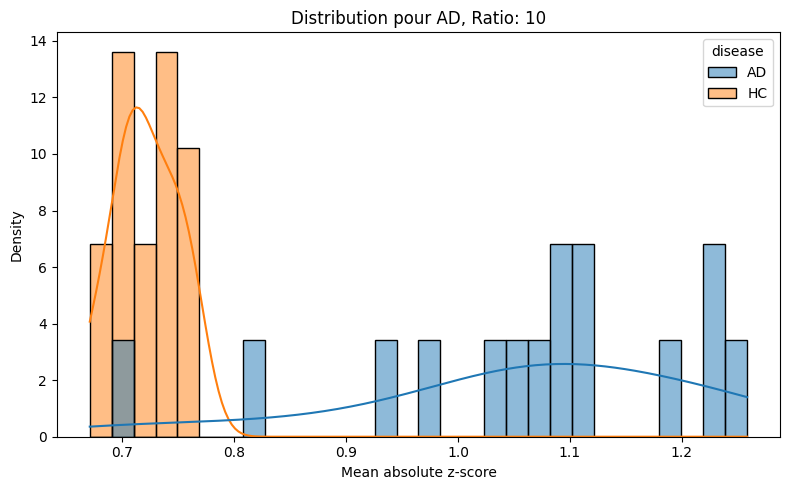

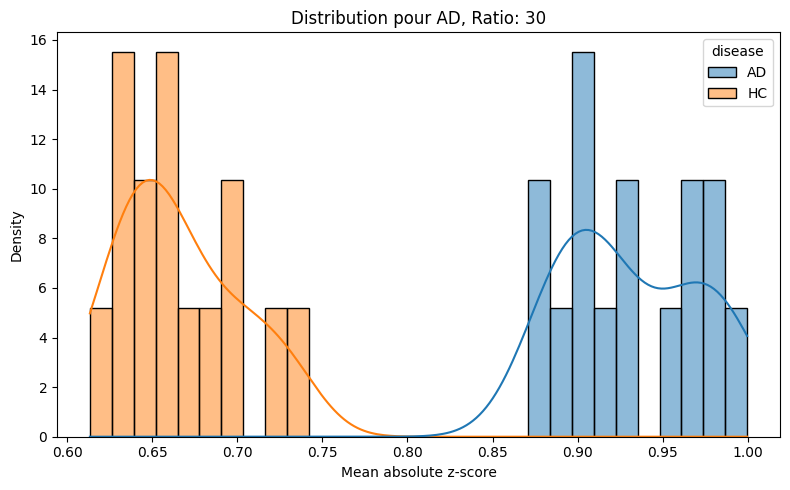

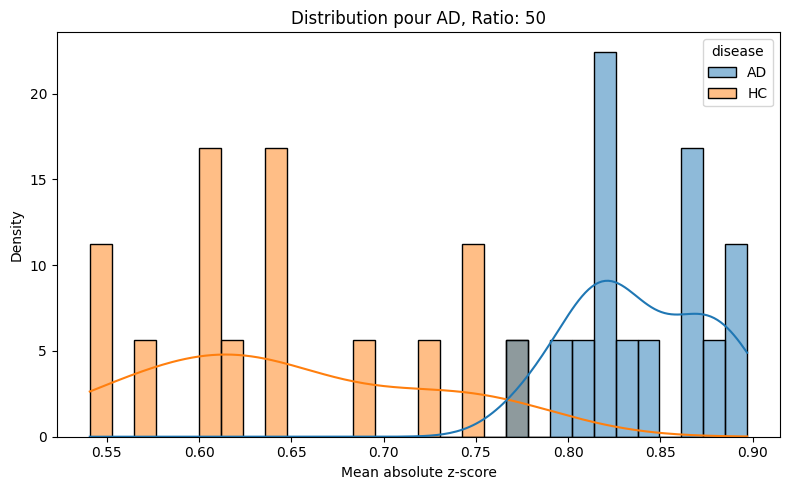

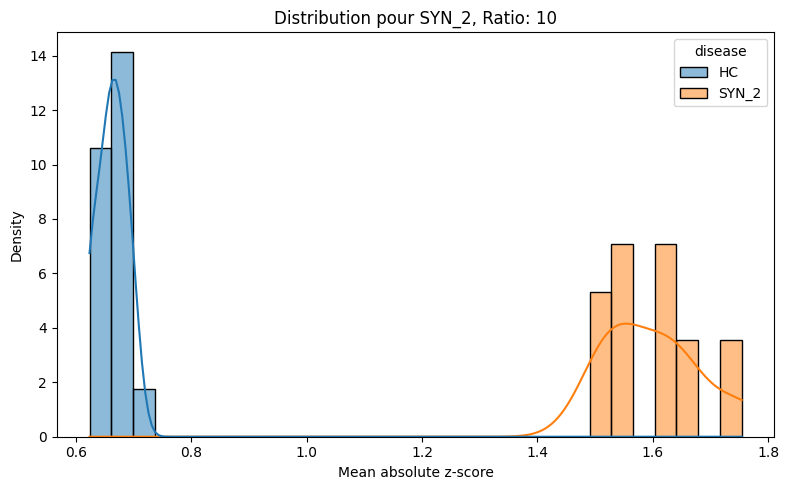

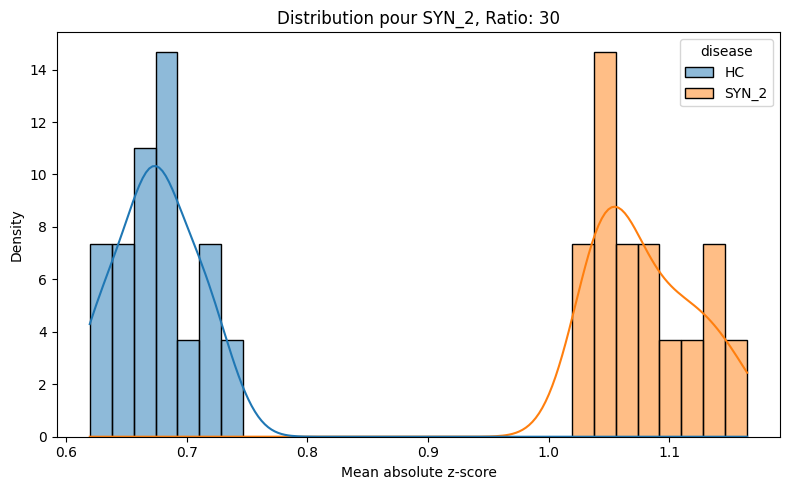

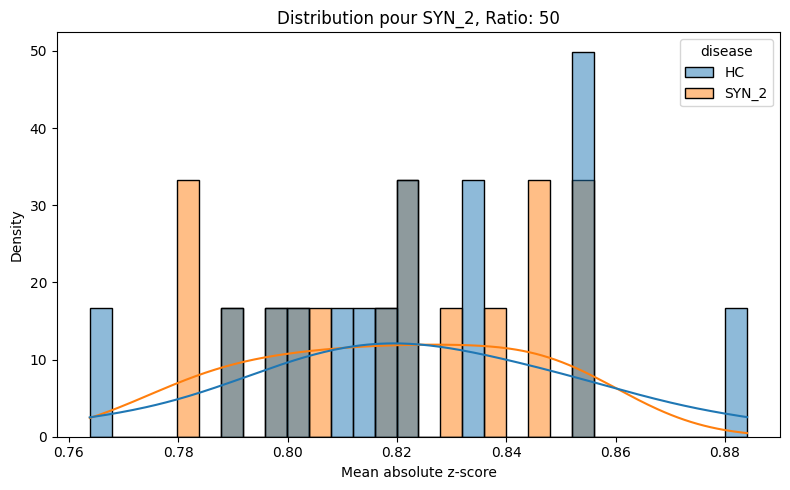

In [16]:
z_score_df = pd.read_csv(os.path.join(MAINFOLDER, "z_score_compilation_global.csv"))

by_site = z_score_df.groupby(["site", "disease_site", 'disease'])["mean_abs_zscore"].mean().reset_index()
by_site = add_nb_patients_and_diseased(by_site)
by_site = by_site.drop(columns=["num_diseased", "num_patients"])
print('s')

for (disease_site, disease_ratio), sub_df in by_site.groupby(["disease_site", "disease_ratio"]):
    plt.figure(figsize=(8, 5))
    
    sns.histplot(
        data=sub_df,
        x="mean_abs_zscore",
        hue="disease",
        kde=True,
        stat="density",
        common_norm=False,
        bins=30
    )
    
    plt.title(f"Distribution pour {disease_site}, Ratio: {disease_ratio}")
    plt.xlabel("Mean absolute z-score")
    plt.ylabel("Density")
    plt.tight_layout()
    plt.show()



In [ ]:
z_score_df = pd.read_csv(os.path.join(MAINFOLDER, "z_score_compilation_global.csv"))

by_site = add_nb_patients_and_diseased(z_score_df)
by_site = by_site.drop(columns=["num_diseased", "num_patients"])
print('s')

for (disease_site, disease_ratio), sub_df in by_site.groupby(["disease_site", "disease_ratio"]):
    plt.figure(figsize=(8, 5))
    
    sns.histplot(
        data=sub_df,
        x="mean_abs_zscore",
        hue="disease",
        kde=True,
        stat="density",
        common_norm=False,
        bins=30
    )
    
    plt.title(f"Distribution pour {disease_site}, Ratio: {disease_ratio}")
    plt.xlabel("Mean absolute z-score")
    plt.ylabel("Density")
    plt.tight_layout()
    plt.show()

